In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from configuration import *
import pandas as pd

import spikeinterface.full as si

from spikeinterface.sortingcomponents.benchmark.benchmark_motion_correction import BenchmarkMotionCorrectionMearec

from figure_waveforms_distortion import plot_template_and_std, plot_distortion_distribution, plot_corrected_spike_locations
import spikeinterface.full as si

from plotting_tools import removeaxis, label_panel

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5


In [3]:
plt.rcParams.update({
    'font.size': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

In [24]:
figure_folder = base_folder / 'figures' / 'interpolation'
figure_folder.mkdir(exist_ok=True, parents=True)

ext = 'png'
ext = 'pdf'

In [5]:
drift_cases = [
    ('uniform', 'homogeneous', 'rigid'),
    ('uniform', 'homogeneous', 'bumps'),
]


interpolation_methods = ['kriging', 'idw', 'nearest', ]
# interpolation_methods = ['kriging', ]

In [6]:
all_benchmarks = {}
for cells_position, cells_rate, drift_mode   in drift_cases:
    all_benchmarks[(cells_position, cells_rate, drift_mode)] = {}
    for interpolation_method in interpolation_methods:
        benchmark_folder = base_folder / 'bench_interpolation' / f'{probename}_{drift_mode}_{cells_position}_{cells_rate}' / f'{interpolation_method}'
        bench = BenchmarkMotionCorrectionMearec.load_from_folder(benchmark_folder)
        all_benchmarks[(cells_position, cells_rate, drift_mode)][interpolation_method] = bench

## waveforms distrotions on bumps

In [7]:
benchmarks_bumps = all_benchmarks[('uniform', 'homogeneous', 'bumps')]

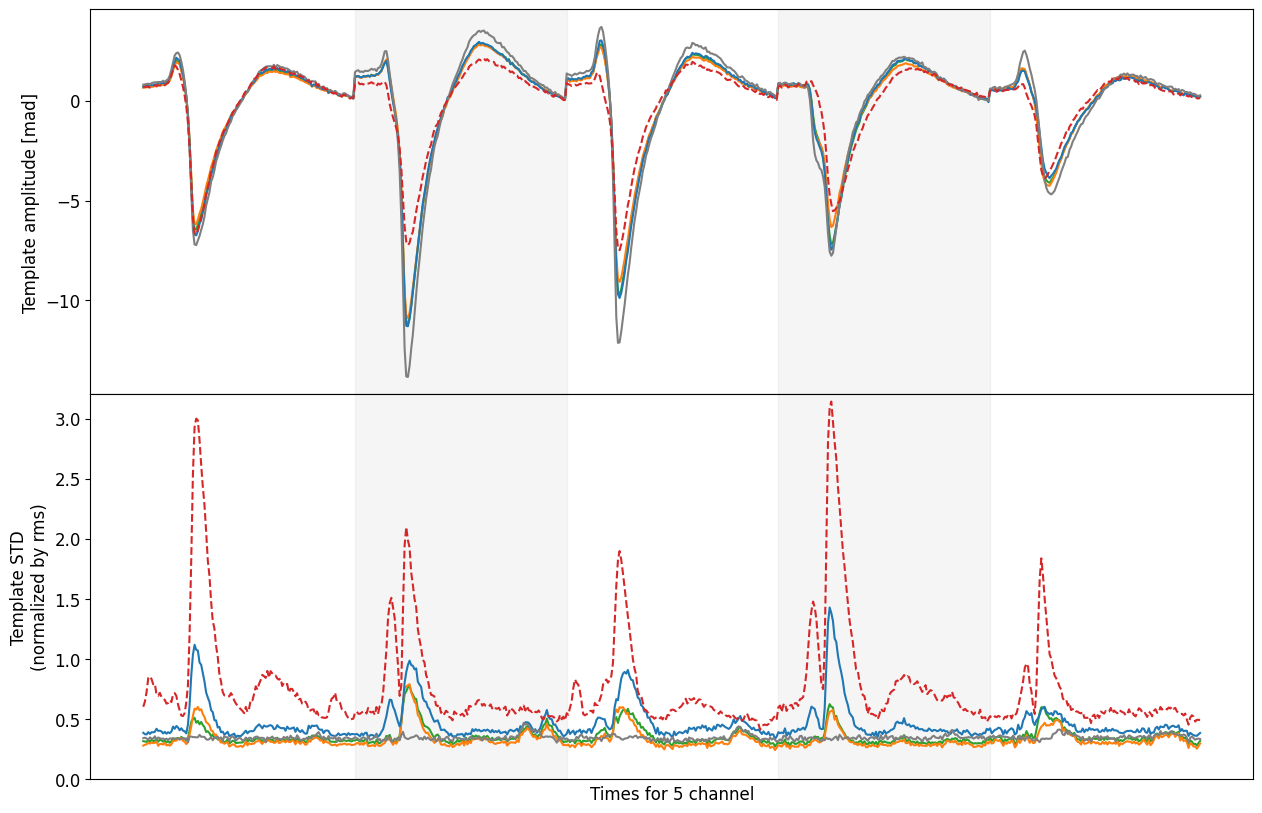

In [14]:
fig = plot_template_and_std(benchmarks_bumps, '#100')
fig.savefig(figure_folder / f'Figure5B_template_std.{ext}')

In [9]:
for method, bench in benchmarks_bumps.items():
    bench.compute_distances_to_static(force=True)

static
drifting
corrected_gt
corrected_estimated
static
drifting
corrected_gt
corrected_estimated
static
drifting
corrected_gt
corrected_estimated


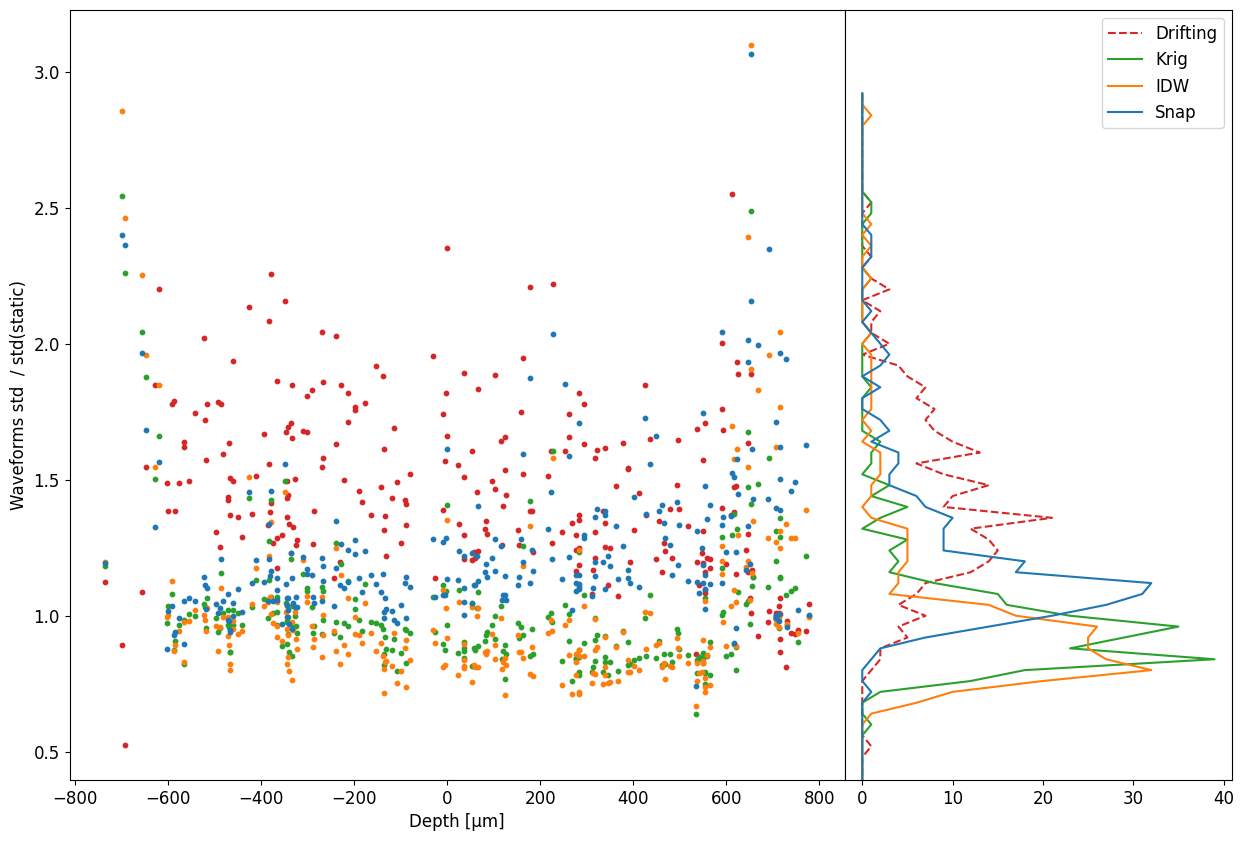

In [10]:
fig = plot_distortion_distribution(benchmarks_bumps, metric='norm_std', bins=np.arange(0, 3, 0.04))
fig.savefig(figure_folder / f'Figure5C_distortion_distribution.{ext}')

## raster corrected on zigzag

In [15]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks


In [16]:
benchmarks_rigid = all_benchmarks[('uniform', 'homogeneous', 'rigid')]


In [20]:

bench = next(iter(benchmarks_rigid.values()))
static_we = bench.waveforms['static']
drifting_we = bench.waveforms['drifting']

job_kwargs = dict(n_jobs=20, progress_bar=True, chunk_duration='1s')
# method ='center_of_mass'
# method_kwargs = dict(local_radius_um=100)

method ='monopolar_triangulation'
method_kwargs = dict(feature='peak_voltage', local_radius_um: 75.)


peaks_locations = {}


rec = static_we.recording
peaks = detect_peaks(rec, method='locally_exclusive', detect_threshold=12, **job_kwargs)
locations = localize_peaks(rec, peaks, method=method, **method_kwargs, **job_kwargs)
peaks_locations['static'] = peaks, locations

rec = drifting_we.recording
peaks = detect_peaks(rec, method='locally_exclusive', detect_threshold=12, **job_kwargs)
locations = localize_peaks(rec, peaks, method=method, **method_kwargs, **job_kwargs)
peaks_locations['drifting'] = peaks, locations


for interpolation_method, bench in benchmarks_rigid.items():
    rec = bench.waveforms['corrected_gt'].recording
    peaks = detect_peaks(rec, method='locally_exclusive', detect_threshold=12, **job_kwargs)
    locations = localize_peaks(rec, peaks, method=method, **method_kwargs, **job_kwargs)
    peaks_locations[interpolation_method] = peaks, locations
    
print(peaks_locations.keys())



detect peaks using locally_exclusive:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/600 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/600 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/600 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/600 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/600 [00:00<?, ?it/s]

dict_keys(['static', 'drifting', 'kriging', 'idw', 'nearest'])


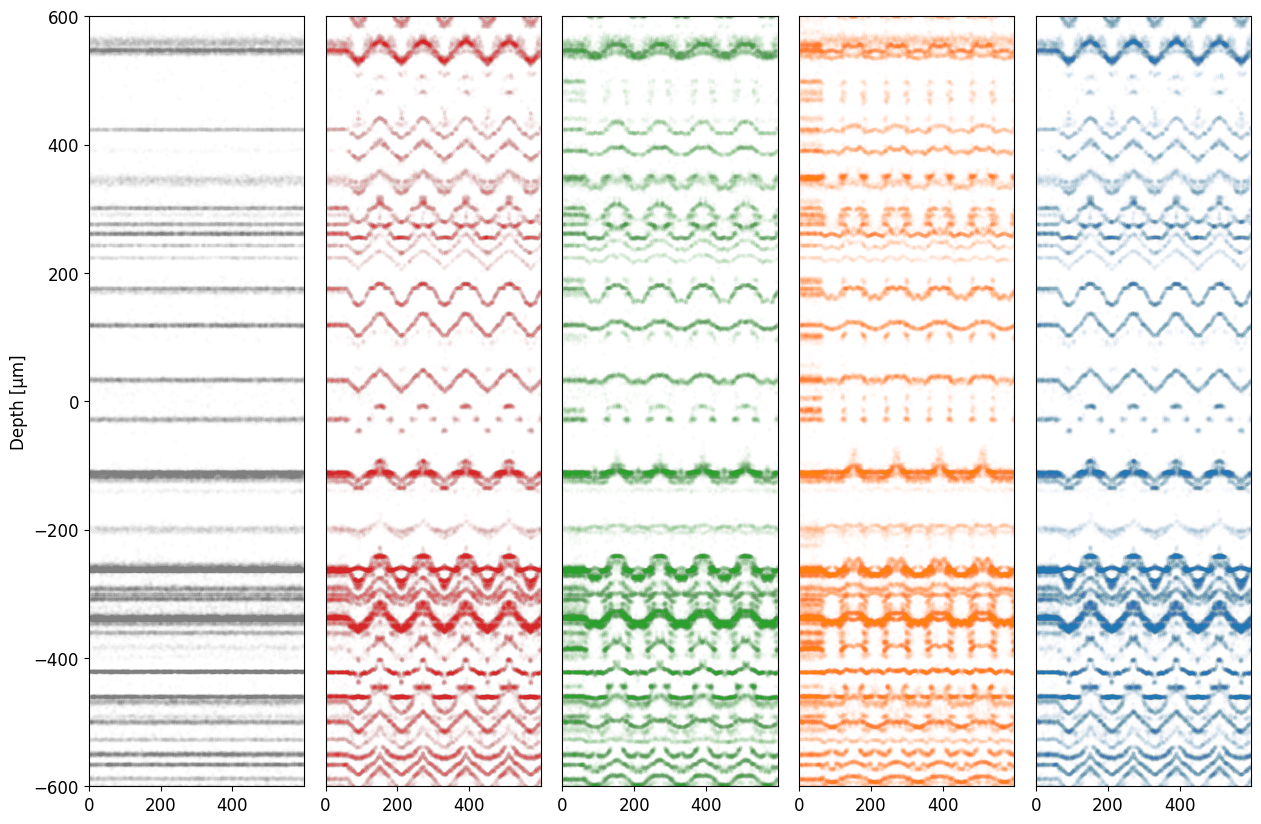

In [21]:
fig = plot_corrected_spike_locations(benchmarks_rigid, peaks_locations)
fig.savefig(figure_folder / f'Figure5A_corrected_spike_locations.{ext}')

## final figure

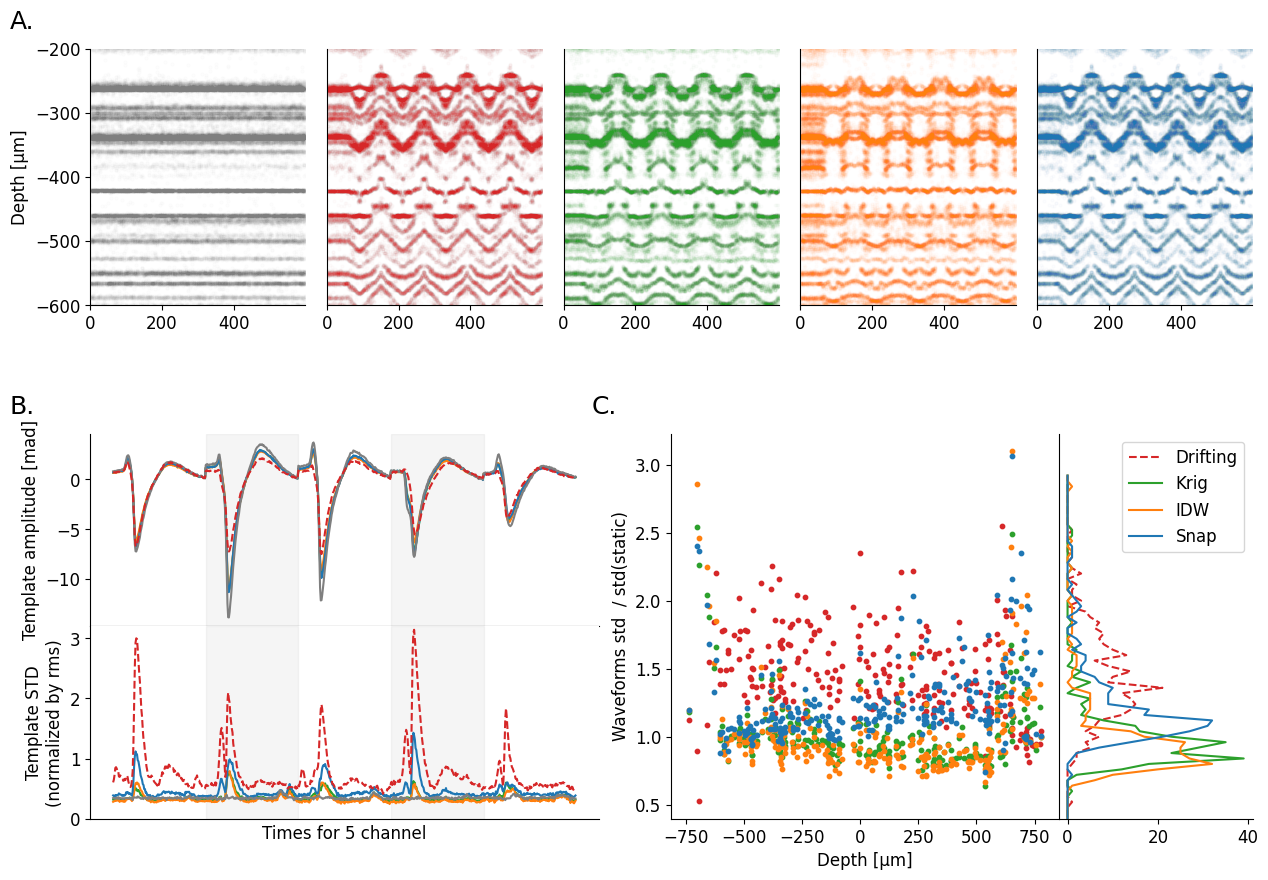

In [25]:
figsize=(15,10)
fig = plt.figure(figsize=figsize)

gs0 = fig.add_gridspec(2, 5, wspace=0.1, hspace=1.0)
axes0 = [fig.add_subplot(gs0[0, i]) for i in range(5) ]

plot_corrected_spike_locations(benchmarks_rigid, peaks_locations,  axes=axes0)

for ax in axes0:
    ax.set_ylim(-600, -200)


label_panel(axes0[0], 'A')


benchmarks = all_benchmarks[('uniform', 'homogeneous', 'bumps')]
gs1 = fig.add_gridspec(4, 6, wspace=2., hspace=0.0)
ax5 = fig.add_subplot(gs1[2, 0:3])
ax6 = fig.add_subplot(gs1[3, 0:3])

plot_template_and_std(benchmarks_bumps, '#100', axes=[ax5, ax6])
label_panel(ax5, 'B')

gs2 = fig.add_gridspec(2, 6, wspace=0., hspace=0.0)
ax7 = fig.add_subplot(gs2[1, 3:5])
ax8 = fig.add_subplot(gs2[1, 5])

plot_distortion_distribution(benchmarks_bumps, metric='norm_std', bins=np.arange(0, 3, 0.04), axes=[ax7, ax8])
label_panel(ax7, 'C')

for ax in axes0 + [ax5, ax6, ax7, ax8]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


fig.savefig(figure_folder / f'Figure5_distortion.{ext}')